In [1]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import powerlaw
import numpy as np
from sklearn.linear_model import LinearRegression
import statistics

In [2]:
with open('fs_inst_following.json', 'r', encoding='utf-8') as f:
    graph_dict = json.load(f)

# Network Summary

## Data mining and preprocessing, general charachteristics, basic visualization

This network represents a schema of figure skaters following each other on Instagram (designated as an extremist organization by the Russian government). The data was collected manually by downloading HTML pages from Instagram accounts. Since Instagram uses dynamic page updates, I utilized the `copy_outer_html` function to extract the data. Subsequently, the `BeautifulSoup` was utilized for parsing. Only publicly available accounts were collected to comply with Instagram's policies. The downloaded data can be found in the `insta_follows` folder, the complete preprocessing workflow can be found in `data_parsing.py`, and the graph itself in JSON-format is located in `fs_inst_following.json`.

The data was collected using a balanced sampling approach. Figure skating comprises four disciplines: **women's singles**, **men's singles**, **pairs**, and **ice dance**. To minimize bias, an equal number of skaters was selected from each category: 26 women's singles skaters, 26 men's singles skaters, 26 pairs skaters (comprising 13 men and 13 women), 26 ice dance skaters (similarly, 13 men and 13 women). In total, 104 accounts were analyzed.

The network thus has the following charachteristics:
- each node represents an athlete's Instagram account; there are **104 nodes** in total;
- overall, **N** edges are represented;
- each directed edge represents a "following" relationship between two accounts, meaning the network is **directed**;
- all edges have equal weight, meaning the network is **unweighted**;
- the set of nodes is **homogeneous**, as all individuals belong to the same professional community (elite figure skating).

!!!!! The nodes have following attributes:
- figure skating discipline;
- a merit-based point score for each skater, calculated according to [ISU World Standings and Season's World Ranking](https://en.wikipedia.org/wiki/ISU_World_Standings_and_Season%27s_World_Ranking)

In [3]:
G = nx.DiGraph()

G.add_nodes_from(graph_dict.keys())
for follower, following_list in graph_dict.items():
    for following in following_list:
        if following in graph_dict.keys():
            G.add_edge(follower, following)

# short descriptives
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 78, Edges: 1447


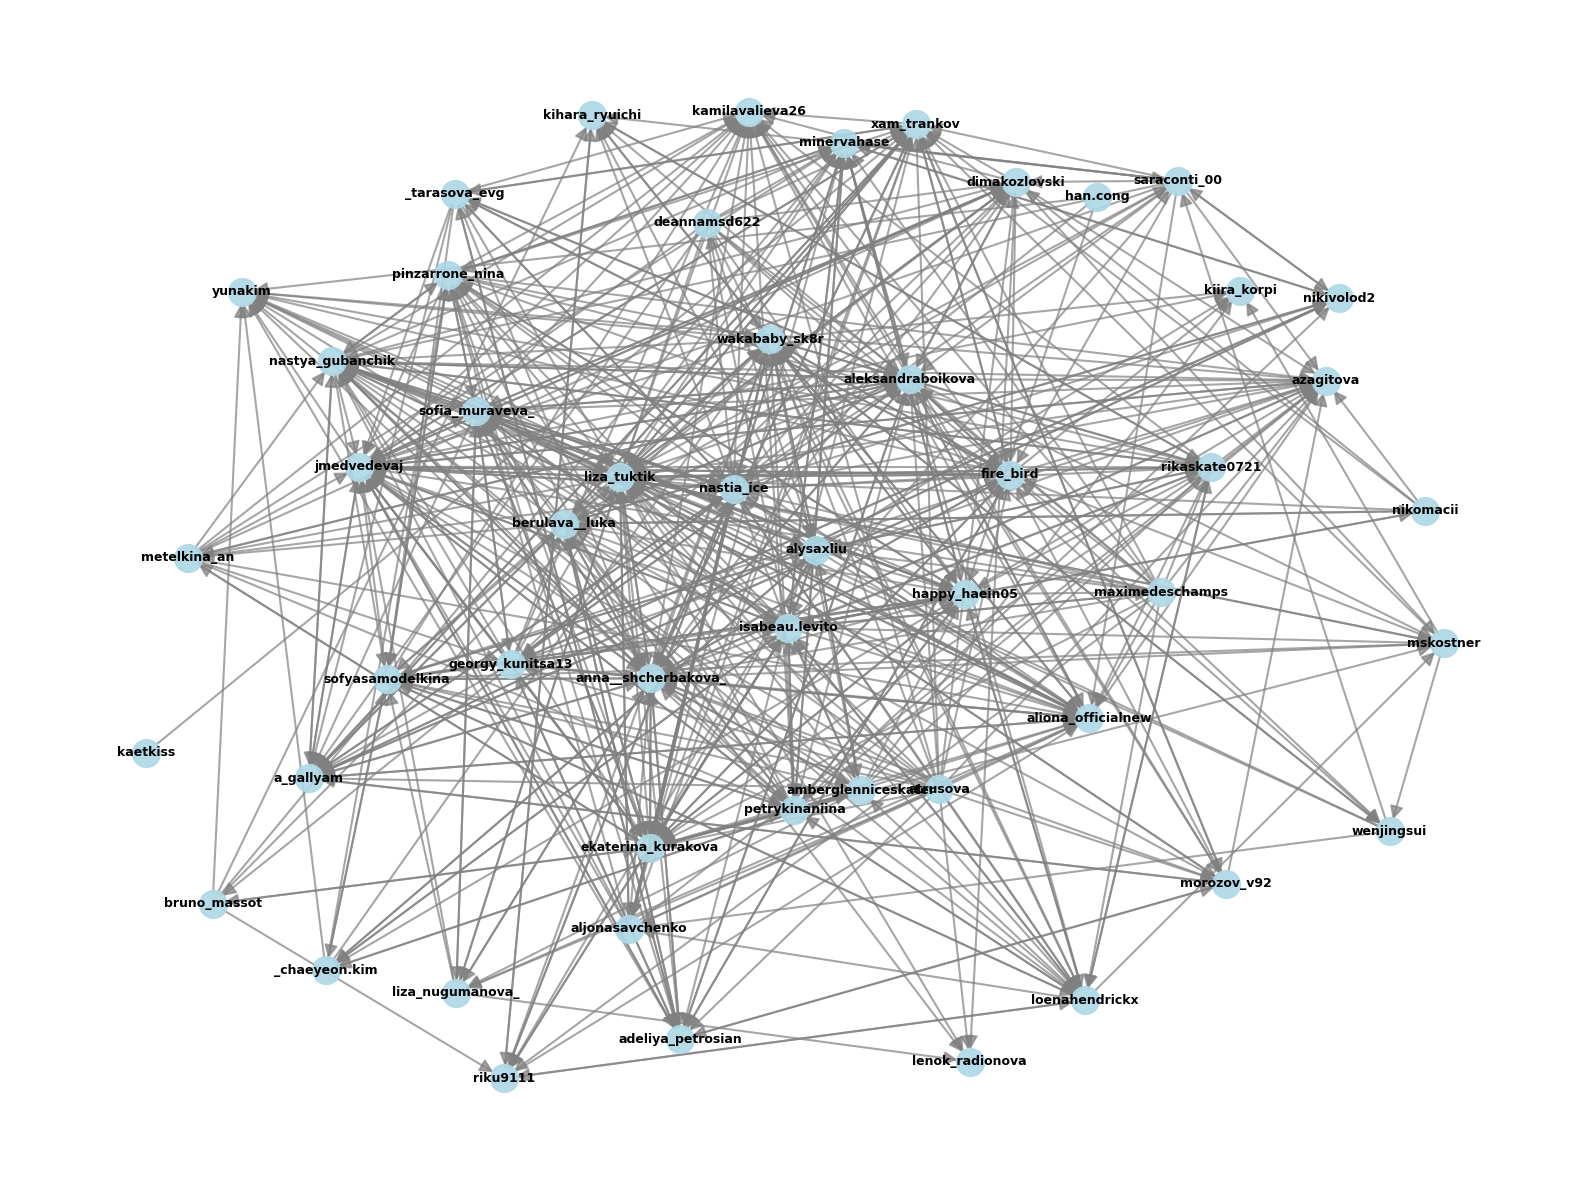

In [4]:
# basic visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

plt.axis('off')

plt.tight_layout()
plt.show()

## Degree distribution: checking whether the network is scale-free

To determine whether a network exhibits scale-free properties, we need to examine whether its degree distribution follows a power law. Since we are working with a directed graph, we will analyze the distribution of total degrees for each node, calculated by summing the in-degree and out-degree values for every node.

The Kolmogorov-Smirnov test was used to assess the goodness-of-fit between the empirical degree distribution and a theoretical power-law model. To perform this analysis, a `Fit` object from the `powerlaw` library was created. It automatically fits a power-law distribution to the data by finding the optimal lower bound (`xmin`) where the power-law behavior begins. The fit's quality (goodness of fit) is quantified by the Kolmogorov-Smirnov statistic (D) (`.KS()` method). This statistic measures the maximum distance between the  CDF of the empirical data and the CDF of the fitted theoretical power-law model. A smaller D value indicates a better fit.

In [21]:
degrees = [G.in_degree()[node] + G.out_degree()[node] for node in G.nodes]

In [57]:
fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
print(f"Optimal lower bound: {fit.xmin}")
print(f"Power law exponent (alpha): {fit.alpha:.3f}")
print(f"D-value of Kolmogorov-Smirnov test: {fit.power_law.KS():.3f}")

Optimal lower bound: 32.0
Power law exponent (alpha): 6.263
D-value of Kolmogorov-Smirnov test: 0.123


The analysis of the empirical degree distribution using the Kolmogorov-Smirnov (KS) goodness-of-fit test indicates that the observed network does not exhibit scale-free properties: the usual threshold for satiafactory fitting is <.05, and we have 0.123. 

I compared the empirical distribution against a theoretical null model using a random network of comparable size and density. For this purpose, the Erdős–Rényi random graph model will be implemented to generate a graph with an equal number of nodes and an approximate matching of the average degree.

In [81]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

def random_edges(nodes, p):
    edges = []
    np.random.seed(42)
    for i in nodes:
      for j in range(i+1, len(nodes)):
        r = np.random.random()
        if r <= p:
          edges.append((i, j))
    return np.array(edges)

In [89]:
real_av_nd = statistics.mean([tuple_degree[1] for tuple_degree in G.degree])
real_num_n = len(G.nodes)
random_graph = erdos_renyi_graph(real_num_n, real_av_nd/real_num_n)
random_degrees = [i for i in dict(random_graph.degree).values()]

fit = powerlaw.Fit(random_degrees, discrete=True, verbose=False)
print(f"Optimal lower bound for random graph: {fit.xmin}")
print(f"Power law exponent (alpha) for random graph:: {fit.alpha:.3f}")
print(f"D-value of Kolmogorov-Smirnov test for random graph:: {fit.power_law.KS():.3f}")

Optimal lower bound for random graph: 23.0
Power law exponent (alpha) for random graph:: 10.786
D-value of Kolmogorov-Smirnov test for random graph:: 0.146


The random network also cannot be fitted to power-law appropriately. Also the degree distribution exhibits a heavy tail (according to the xmin parametr, which is 32), but one that is significantly shallower and better fitted by a power law than that of a random network (xmin is 23). This indicates the presence of non-random connection mechanisms, although the resulting hub structure remains extremely exclusive compared to classic scale-free networks.

In [90]:
# vizualisation

## Average distance + small-world + clustering coeff

In [97]:
max(list(nx.strongly_connected_components(G)), key=len)

{'_chaeyeon.kim',
 '_tarasova_evg',
 'a_gallyam',
 'adeliya_petrosian',
 'aleksandraboikova',
 'aliona_officialnew',
 'aljonasavchenko',
 'alysaxliu',
 'amberglenniceskater',
 'anna__shcherbakova_',
 'azagitova',
 'berulava__luka',
 'bruno_massot',
 'deannamsd622',
 'dimakozlovski',
 'ekaterina_kurakova',
 'fire_bird',
 'georgy_kunitsa13',
 'happy_haein05',
 'isabeau.levito',
 'jmedvedevaj',
 'kihara_ryuichi',
 'liza_nugumanova_',
 'liza_tuktik',
 'loenahendrickx',
 'maximedeschamps',
 'metelkina_an',
 'minervahase',
 'morozov_v92',
 'mskostner',
 'nastia_ice',
 'nastya_gubanchik',
 'nikivolod2',
 'nikomacii',
 'petrykinaniina',
 'pinzarrone_nina',
 'rikaskate0721',
 'riku9111',
 'saraconti_00',
 'sofia_muraveva_',
 'sofyasamodelkina',
 'wakababy_sk8r',
 'wenjingsui',
 'xam_trankov'}

## Gorgeous network layout

# Structural Analysis

# Community detection